<a href="https://colab.research.google.com/github/ntminh981/ApplyParallelProgramming_Group5/blob/main/Parallel/PoissionMatting_Parallel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PARALLEL POISSION MATTING

## Nhóm 5


1.   Nguyễn Tấn Minh - 19127473
2.   Phạm Cao Minh - 19127474



# 1. Clone git project

In [ ]:
import os
if not os.path.exists('/content/git'):
  !git clone https://github.com/ntminh981/ApplyParallelProgramming_Group5.git git

# 2. Khai báo thư viện

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.express as px
import os
from  scipy import ndimage
import time
import scipy
from scipy.optimize import fmin

import os
from numba import cuda, jit

# 3. Load & show input

In [ ]:
IMAGES_FOLDER_PATH  = "/content/git/img"
img_name            = 'img3.png'
trimap_name         = 'tri3.png'
# img_name            = 'leaf.jpg'
# trimap_name         = 'leaf_tri.jpg'
new_bg_name         = 'new_bg3.jpg'

In [ ]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    """
    Utility Function to Display Images
    :param img_arr : List of numpy array representing images
    :param r: Number of rows in the subplot
    :param c: Number of coloumns in the subplot
    :param dim: Figure Size of the subplot
    :param titles_arr: Title corresponding to each image in img_arr
    """
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()

def read_img(im_names,path=IMAGES_FOLDER_PATH):
    """
    Utitlity Function to Read Images from file
    :param im_names: Name of the image file in the images folder, directed using the IMAGES_FOLDER_PATH variable
    :return: Two seperate lists containing the colored and grayscale version of images as numpy array
    """
    im = []
    im_gray = []
    for name in im_names:
        img =  cv2.imread(path+'/'+name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if(len(im)>=1):
            img = cv2.resize(img,(im[0].shape[1],im[0].shape[0]))
        im.append(img)
        im_gray.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return im, im_gray

In [ ]:
img = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, img_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, img_name),0)
tri = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, trimap_name),0)

new_bg = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, new_bg_name))
new_bg = cv2.cvtColor(new_bg, cv2.COLOR_BGR2RGB)
new_bg = cv2.resize(new_bg, (img.shape[1],img.shape[0]))

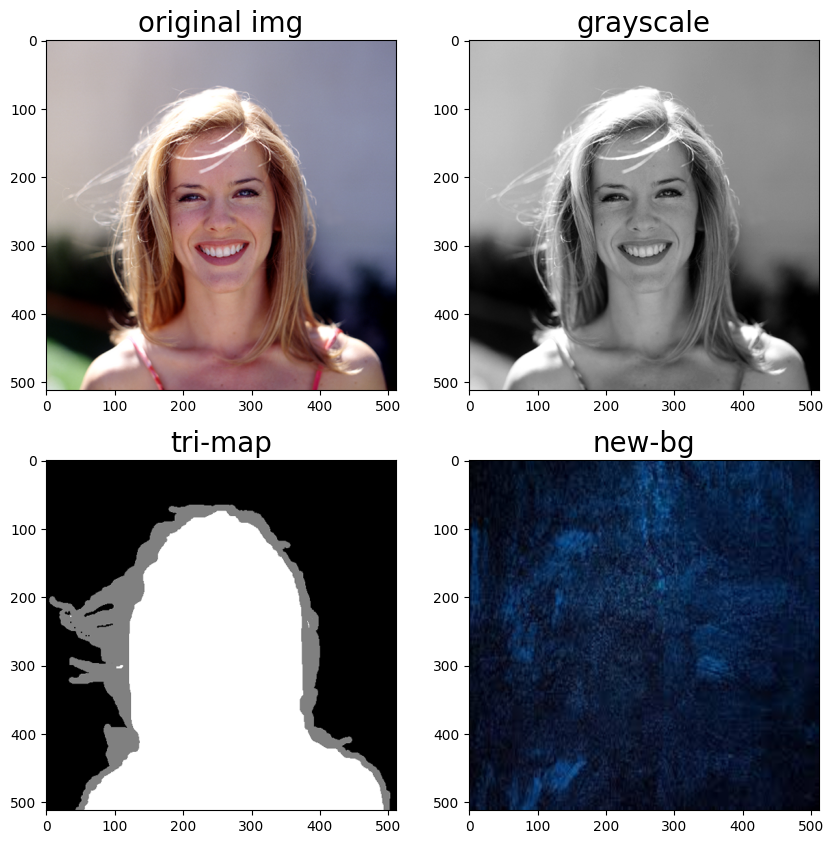

In [ ]:
display_img_arr([img,img_gray,tri,new_bg], 2,2,(10,10), ['original img','grayscale','tri-map','new-bg'])

# 4. Global Matting

+ 1 image có thể được biểu diễn như sau:

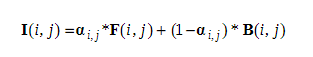

+ Đạo hàm 2 vế:

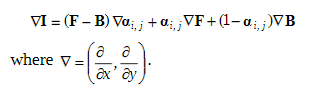

+ Giả sử foreground và background smooth, tức là $\Delta F$ và $\Delta B$ tiệm cận 0:
$$\nabla I=(F-B)\nabla \alpha ⟹ \nabla \alpha =\frac{\nabla I}{F-B}$$

+ Poisson Equation
$$\Delta \alpha = div (\frac{\nabla I}{F-B})$$
where, $\Delta = (\frac{\partial^2}{\partial x^2},\frac{\partial^2}{\partial y^2})$
is Laplacian Operator and div is divergence opertor

+ Giải Poisson Equation bằng Phép lặp Gauss Siedel với phương pháp overrealaxation.

 Với,  $$ \frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2} = S$$
$$ {f_{i,j}}^{(n+1)} = \frac{\beta}{4}({f_{i+1,j}}^{(n)} + {f_{i-1,j}}^{(n+1)} + {f_{i,j+1}}^{(n)} + {f_{i,j-1}}^{(n+1)} - S_{i,j}) + (1-\beta){f_{i,j}}^{(n)}$$

$\beta$ nằm trong khoảng [1,2] (chọn $\beta$=1)



## Thiết kế song song

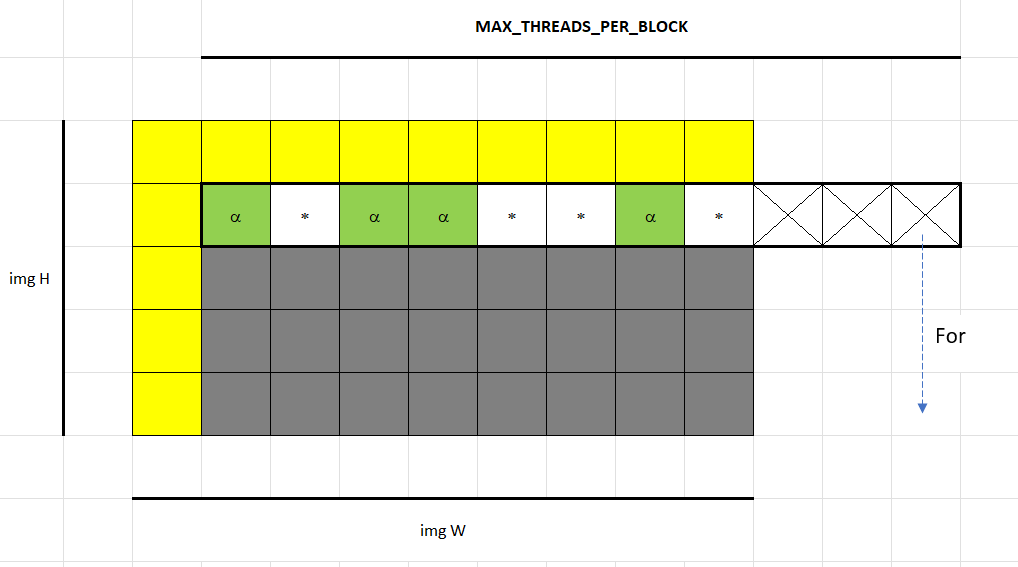

Phép toán ở mỗi pixel (i, j) sẽ phụ thuộc vào pixel không phải là unknown ở bên trái (i, j-1) và bên trên (i-1, j) của nó , và những pixel unknown sau thực hiện tính xong cũng sẽ được đánh dấu là không phải unknown.

Do đó nhóm sẽ thực hiện song song theo từng hàng. Mỗi block sẽ là mảng 1 chiều với kích thước (MAX_THREADS_PER_BLOCK, 1). Với những pixel có 1 trong 2 pixel bên trái hoặc bên trên của nó là unknown, thread sẽ chờ tới khi cả 2 giá trị đó được tính toán xong.

## Implement

### Utils

In [ ]:
from posixpath import join
def calc_masks(tri, img_gray):
    """
    Utility Function to Create Masks
    :param tri: A numpy array representing the trimap of the image in Grayscale
    :param img_gray: A numpy array representing the Grayscale version of the image
    :return A list of numpy array representing the foreground mask, foreground image, background mask,
            background image, unknown region mask,unknown region image
    """
    mask_bg = (tri<10)
    mask_fg = (tri>245)
    mask_unknown = (np.bitwise_and(tri>=10,tri<=245))

    fg = img_gray*(mask_fg)
    bg = img_gray*(mask_bg)
    unknown = img_gray*mask_unknown
    return [mask_fg,fg,mask_bg,bg,mask_unknown,unknown], ['fg mask','fg','bg mask','bg','mask unknown','unkown reg img']

def fb(img_gray,mask_fg,mask_bg,mask_unknown):
    """
    Utility Function to find the Approximate Foreground and Approximate Background using the Trimap provided
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param mask_bg: A numpy array representing the pixels in the Background Region
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region
    :returns :Two numpy arrays representing Approximate Foreground and Approximate Background respectively
    """
    F = img_gray*(mask_fg+mask_unknown)
    B = img_gray*(mask_bg+mask_unknown)
    return F, B

def globalAlphaMatting(alpha,d2alpha,unknown_seg,iters = 50, threshold = 0.1, beta = 1):
    """
    Implements Global Matting as discussed in the paper. Using image gradients, Approximate Foreground and Approximate
    Background, it solves the Poisson Equation with the help of Gauss Siedel Approximation
    :param alpha: The Estimated value of Alpha for the Final Matte
    :param d2alpha: Sum of Double Differential in X and Y. Required to solve the Poisson Equation
    :param unknown_seg: A numpy array representing the pixels in the unknown region of the image/trimap
    :param iters: Number of Iterations the Gauss Siedel Approximation wil run
    :param threshold: If the amount of change happening after each iteration is below threshold, the program will end
    :param beta: The Beta Factor involved in Gauss Siedel Approximation

    :returns :A numpy array representing Matte produced and time taken to calculate it
    """
    prev_alpha = np.zeros(alpha.shape)

    tic = time.time()
    for _ in range(iters):
        diff = np.sum(np.abs(prev_alpha-alpha))
        if diff < threshold:
            break
        for i in range(1,alpha.shape[0]-1):
            for j in range(1,alpha.shape[1]-1):
                if unknown_seg[i,j]!=0 :
                    alpha[i,j] = ((beta*(alpha[i,j-1]+alpha[i-1,j]+prev_alpha[i,j+1]+prev_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*prev_alpha[i,j])

        prev_alpha = alpha.copy()
    tac = time.time()
    return alpha, tac-tic

def grads(F,B,mask_fg,img_gray,mask_unknown):
    """
    Finding the Gradient and Difference required for the Poisson Equation and
    the Estimate Alpha for Global Mating
    :param F: A numpy array representing Approximate Foreground
    :param B: A numpy array representing Approximate Background
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region

    :returns :A numpy array representing the estimate alpha, A numpy array representing Double Differential
               A numpy array representing the difference of Approximate Foreground and Background
    """
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)
    grad_y,grad_x = np.gradient(img_gray)
    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient(grad_y/diff)
    _, d2x_alpha = np.gradient(grad_x/diff)
    d2alpha = d2y_alpha + d2x_alpha
    estimate_alpha = mask_fg + 0.5*mask_unknown
    return estimate_alpha, d2alpha, diff

def func_estimate_alpha(tri, img_gray):
    """
    Main Function to calculate the estimate alpha
    :params tri: trimap
    :params img_gray: gray input image
    :returns estimated alpha
    """
    imgs, titles = calc_masks(tri, img_gray)
    display_img_arr(imgs, 3,2,(10,10),titles)
    mask_fg, fg, mask_bg, bg, mask_unknown, unknown = imgs

    F,B = fb(img_gray,mask_fg,mask_bg,mask_unknown)
    display_img_arr([F,B], 1,2,(10,10),['F','B'])
#     print(mask_fg.shape,fg.shape,mask_bg.shape,bg.shape,mask_unknown.shape,unknown.shape,F.shape,B.shape,img_gray.shape)
    est_alpha, d2alpha, diff =  grads(F,B,mask_fg,img_gray,mask_unknown)
    return est_alpha, F, B, d2alpha, imgs, diff

### Main

In [ ]:
SegmentSize = (img_gray.shape[0], img_gray.shape[1])
d_alpha = cuda.device_array(SegmentSize, dtype=float)
d_d2alpha = cuda.device_array(SegmentSize, dtype=float)
d_unknown = cuda.device_array(SegmentSize, dtype=np.uint8)
d_prev_alpha = cuda.device_array(SegmentSize, dtype=float)

In [ ]:
def copyToDevice(estimate_alpha, d2alpha, unknown):
  global d_alpha, d_d2alpha, d_tmp_unknown, d_prev_alpha

  alpha = estimate_alpha.copy()
  prev_alpha = np.zeros(alpha.shape)

  d_alpha.copy_to_device(alpha)
  d_d2alpha.copy_to_device(d2alpha)
  d_unknown.copy_to_device(unknown)
  d_prev_alpha.copy_to_device(prev_alpha)

@cuda.jit
def globalAlphaMattingParallelRow(row, alpha,prev_alpha,d2alpha,unknown_seg,beta = 1):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    col = tx + ty * bw

    if col < alpha.shape[1]:  # Check array boundaries
      if unknown_seg[row,col]!=0 :
          alpha[row,col] = beta*(alpha[row-1,col]+prev_alpha[row,col+1]+prev_alpha[row+1,col] - d2alpha[row,col])/4

@cuda.jit
def globalAlphaMattingParallelCol(col, alpha,prev_alpha,d2alpha,unknown_seg,beta = 1):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    row = tx + ty * bw

    if row < alpha.shape[0]:  # Check array boundaries
      if unknown_seg[row,col]!=0 :
          alpha[row,col] += beta*(alpha[row,col-1])/4 + (1-beta)*prev_alpha[row,col]

          for i in range(0, row):
            alpha[row,col] += beta*(alpha[i,col-1])/4 + (1-beta)*prev_alpha[i,col]

@cuda.jit
def test(alpha,prev_alpha,d2alpha,unknown_seg,beta = 1):
    i, j = cuda.grid(2)

    if i < alpha.shape[0] and j < alpha.shape[1]:  # Check array boundaries
      if unknown_seg[i,j]:
        pass
          # alpha[i,j] = ((beta*(alpha[i,j-1]+alpha[i-1,j]+prev_alpha[i,j+1]+prev_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*prev_alpha[i,j])

@cuda.jit
def test2(row, alpha,prev_alpha,d2alpha,unknown_seg,beta = 1):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    # row = 1
    col = tx + ty * bw + 1

    k=0
    if col < alpha.shape[1]:  # Check array boundaries
      if unknown_seg[row,col]:
        while unknown_seg[row-1,col] or unknown_seg[row,col-1]:
          k+=1
        alpha[row,col] = beta*(alpha[row-1,col]+alpha[row,col-1]+prev_alpha[row,col+1]+prev_alpha[row+1,col] - d2alpha[row,col])/4
        unknown_seg[row,col] = 0

@cuda.jit
def test3(alpha,prev_alpha,d2alpha,unknown_seg,beta = 1):
    row, col = cuda.grid(2)

    k=0
    if (col >= 0 and col < alpha.shape[1]) and (row >= 0 and row < alpha.shape[0]):  # Check array boundaries
      if unknown_seg[row,col]:
        while unknown_seg[row-1,col] or unknown_seg[row,col-1]:
          pass
        alpha[row,col] = beta*(alpha[row-1,col]+alpha[row,col-1]+prev_alpha[row,col+1]+prev_alpha[row+1,col] - d2alpha[row,col])/4
        unknown_seg[row,col] = False

@cuda.jit
def test4(alpha,prev_alpha,d2alpha,unknown_seg,beta = 1):
    # # Thread id in a 1D block
    # tx = cuda.threadIdx.x
    # # Block id in a 1D grid
    # ty = cuda.blockIdx.x
    # # Block width, i.e. number of threads per block
    # bw = cuda.blockDim.x
    # # Compute flattened index inside the array
    # # row = 1
    # col = tx + ty * bw + 1
    row, col = cuda.grid(2)

    if col >= alpha.shape[1]:
      col -= alpha.shape[1]
      row += 1

    if (col > 0 and col < alpha.shape[1]) and (row > 0 and row < alpha.shape[0]):  # Check array boundaries
      if unknown_seg[row,col]:
        while unknown_seg[row-1,col] or unknown_seg[row,col-1]:
          pass
        alpha[row,col] = beta*(alpha[row-1,col]+alpha[row,col-1]+prev_alpha[row,col+1]+prev_alpha[row+1,col] - d2alpha[row,col])/4
        unknown_seg[row,col] = 0

def matting_combined(tri, img_gray, useCuda=0):
    """
    Main Function to calculate the Matte
    :params tri: trimap
    :params img_gray: gray input image
    returns all images dict used for matting: {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown}
    """
    global d_alpha, d_d2alpha, d_tmp_unknown, d_prev_alpha

    estimate_alpha, F, B, d2alpha, imgs, diff = func_estimate_alpha(tri, img_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs

    if useCuda:
      alpha = estimate_alpha.copy()
      prev_alpha = np.zeros(alpha.shape)
      copyToDevice(estimate_alpha, d2alpha, unknown)
      threshold = 0.1

      if useCuda ==1 :
        # Get the current CUDA device
        device = cuda.get_current_device()

        # Get the maximum threads per block for the current device
        max_threads_per_block = device.MAX_THREADS_PER_BLOCK

        block_size = max_threads_per_block
        grid_size = int(np.ceil(img_gray.shape[0]/block_size))

        # compile
        test2[block_size, grid_size](1, d_alpha, d_prev_alpha, d_d2alpha, d_unknown, 1)
        copyToDevice(estimate_alpha, d2alpha, unknown)

        tic = time.time()
        for _ in range(50):
            diff = np.sum(np.abs(prev_alpha-alpha))
            if diff < threshold:
                break

            d_unknown.copy_to_device(unknown)
            d_prev_alpha.copy_to_device(prev_alpha)

            for i in range(1,alpha.shape[0]-1):
                test2[block_size, grid_size](i, d_alpha, d_prev_alpha, d_d2alpha, d_unknown, 1)

            d_alpha.copy_to_host(alpha)
            alpha = np.minimum(np.maximum(alpha,0),1)
            prev_alpha = alpha.copy()

        tac = time.time()
        deltaTime = tac-tic

      elif useCuda == 2:
        block_size = (32, 32)
        grid_size = (int(np.ceil(img_gray.shape[0]/block_size[0])), int(np.ceil(img_gray.shape[1]/block_size[0])))

        # stream1 = cuda.stream()
        # stream2 = cuda.stream()
        # stream3 = cuda.stream()
        # stream4 = cuda.stream()

        half_size_r = alpha.shape[0] // 2
        half_size_c = alpha.shape[0] // 2

        print('[1]')
        # compile
        test3[block_size, grid_size](d_alpha, d_prev_alpha, d_d2alpha, d_unknown, 1)
        copyToDevice(estimate_alpha, d2alpha, unknown)

        tic = time.time()
        for _ in range(50):
            diff = np.sum(np.abs(prev_alpha-alpha))
            if diff < threshold:
                break

            d_unknown.copy_to_device(unknown)
            d_prev_alpha.copy_to_device(prev_alpha)
            print('[2]')

            test3[block_size, grid_size](d_alpha, d_prev_alpha, d_d2alpha, d_unknown, 1)
            # test3[block_size, grid_size, stream1](d_alpha[:half_size_r, :half_size_c], d_prev_alpha[:half_size_r, :half_size_c], d_d2alpha[:half_size_r, :half_size_c], d_tmp_unknown[:half_size_r, :half_size_c], 50, 0.1, 1)
            # test3[block_size, grid_size, stream2](d_alpha[half_size_r:, half_size_c:], d_prev_alpha[half_size_r:, half_size_c:], d_d2alpha[half_size_r:, half_size_c:], d_tmp_unknown[half_size_r:, half_size_c:], 50, 0.1, 1)
            # test3[block_size, grid_size, stream3](d_alpha[:half_size_r, half_size_c:], d_prev_alpha[:half_size_r, half_size_c:], d_d2alpha[:half_size_r, half_size_c:], d_tmp_unknown[:half_size_r, half_size_c:], 50, 0.1, 1)
            # test3[block_size, grid_size, stream4](d_alpha[half_size_r:, :half_size_c], d_prev_alpha[half_size_r:, :half_size_c], d_d2alpha[half_size_r:, :half_size_c], d_tmp_unknown[half_size_r:, :half_size_c], 50, 0.1, 1)

            # stream1.synchronize()
            # stream2.synchronize()
            # stream3.synchronize()
            # stream4.synchronize()
            print('[3]')

            d_alpha.copy_to_host(alpha)
            alpha = np.minimum(np.maximum(alpha,0),1)
            prev_alpha = alpha.copy()
        tac = time.time()
        deltaTime = tac-tic

      elif useCuda == 3 :
        # Get the current CUDA device
        device = cuda.get_current_device()

        # Get the maximum threads per block for the current device
        max_threads_per_block = device.MAX_THREADS_PER_BLOCK

        block_size = (1, max_threads_per_block)
        grid_size = (img_gray.shape[0],1)#int(np.ceil(img_gray.shape[0]/block_size))
        print('blocksize: ', block_size)
        print('gridsize: ', grid_size)

        # compile
        test4[block_size, grid_size](d_alpha, prev_alpha, d2alpha, d_unknown, 1)
        copyToDevice(estimate_alpha, d2alpha, unknown)

        tic = time.time()
        for _ in range(50):
            diff = np.sum(np.abs(prev_alpha-alpha))
            if diff < threshold:
                break

            print(f'[2.1] {_}')
            d_unknown.copy_to_device(unknown)
            print(f'[2.2] {_}')
            d_prev_alpha.copy_to_device(prev_alpha)
            print(f'[2.5] {_}')

            test4[block_size, grid_size](d_alpha, d_prev_alpha, d_d2alpha, d_unknown, 1)

            print(f'[3] {_}')
            print('d_alpha size: ')
            print(d_alpha.shape)
            d_alpha.copy_to_host(alpha)
            alpha = np.minimum(np.maximum(alpha,0),1)
            prev_alpha = alpha.copy()
            print(f'[4] {_}')
        tac = time.time()
        deltaTime = tac-tic

    else:
      alpha, deltaTime = globalAlphaMatting(estimate_alpha,d2alpha,mask_unknown, 50, 0.1, 1)
      alpha = np.minimum(np.maximum(alpha,0),1)

    return {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown, 'time':deltaTime}



In [ ]:
result = {}

## Sequential

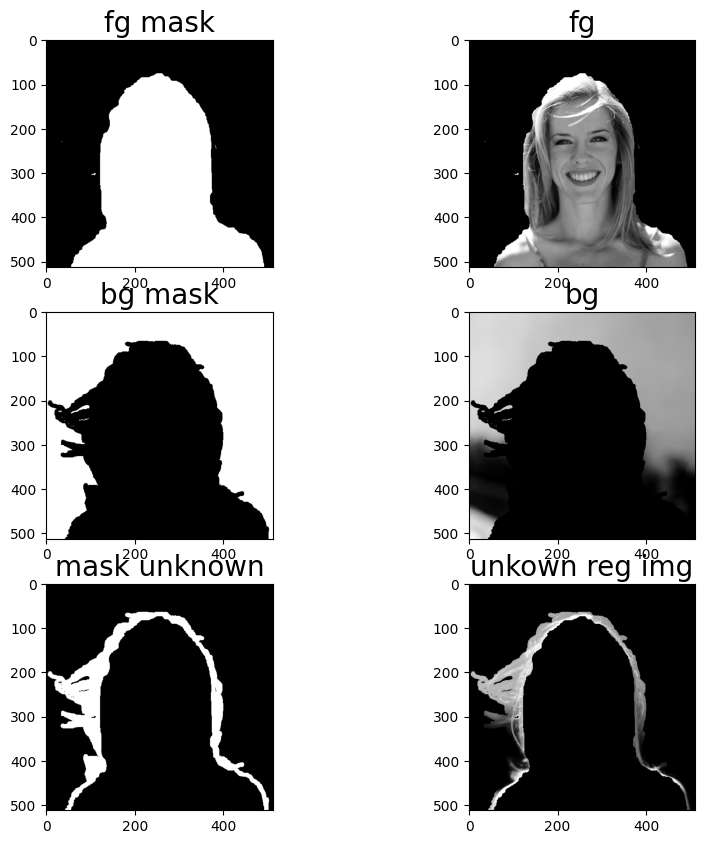

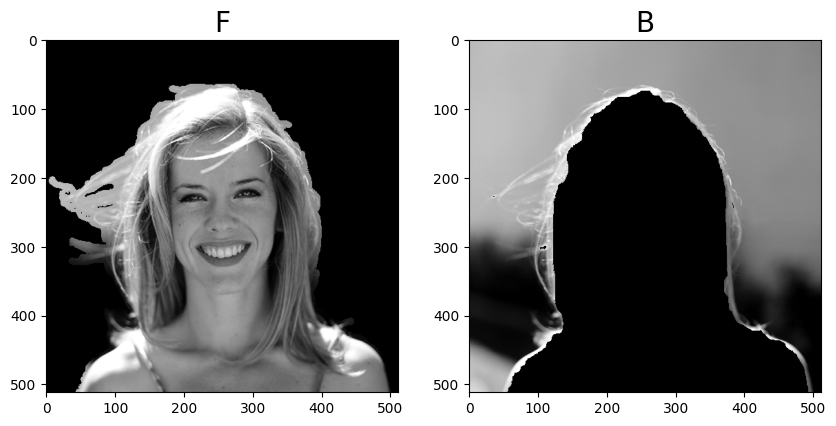

<ipython-input-32-23975e341fe0>:76: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  diff = ndimage.filters.gaussian_filter(diff, 0.9)


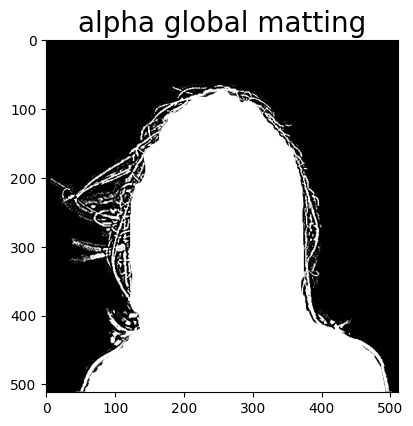

In [ ]:
all_data = matting_combined(tri, img_gray, 0)
## adding images also to this all_data
all_data.update({'img': img, 'img_gray': img_gray})
## NOW all_data VARIABLE CONTAINS img, img_GRAY, ALPHA, DIFF, F, B, UNKNOWN
result['sequential'] = all_data

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])

In [ ]:
print('Sequential version: ', all_data['time'])

Sequential version:  0.42195820808410645


### Alpha blending

#### I = α F + (1 − α )B

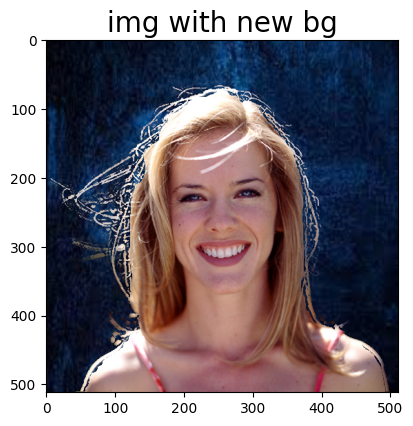

In [ ]:
def alpha_blend(new_bg,alpha,img):
    """
    Utility Function to Calculate the Image on a New Background using the Matte produced by anyone of the methods
    :param new_bg: A numpy array representing the New Background (Coloured)
    :param alpha: A numpy array representing the matte produced
    :param img: Original Image containing the foreground
    """
    new_img = np.zeros(new_bg.shape)
    new_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)*new_bg[:,:,0]
    new_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)*new_bg[:,:,1]
    new_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)*new_bg[:,:,2]
    return np.int64(new_img)

new_img = alpha_blend(new_bg,all_data['alpha'],img)
display_img_arr([new_img ], 1,2,(10,10),['img with new bg'])

## Parallel

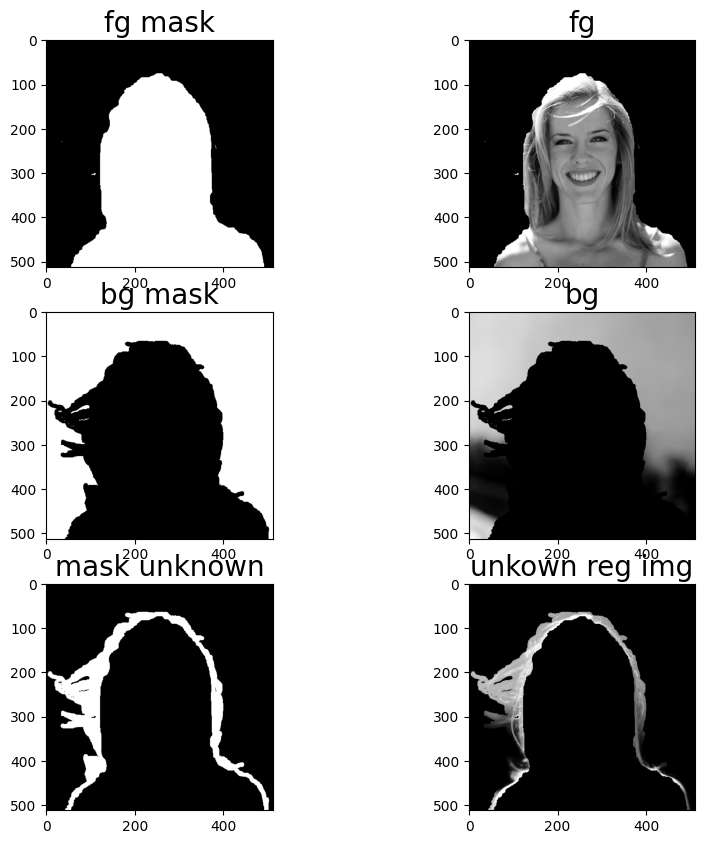

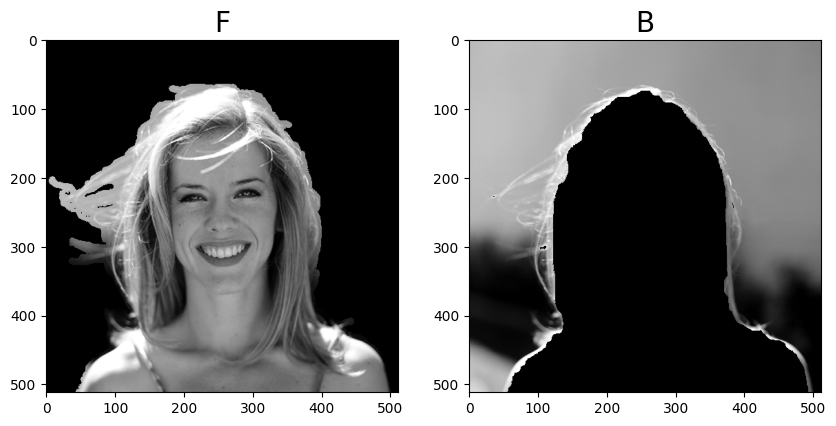

<ipython-input-32-23975e341fe0>:76: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  diff = ndimage.filters.gaussian_filter(diff, 0.9)


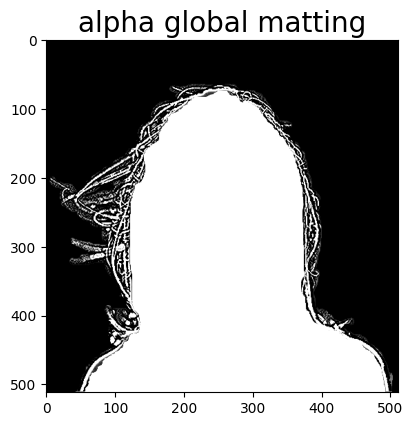

In [ ]:
all_data = matting_combined(tri, img_gray, 1)
## adding images also to this all_data
all_data.update({'img': img, 'img_gray': img_gray})
all_data_3 = all_data.copy()

result['version_1'] = all_data

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])

In [ ]:
print('Parallel version: ', all_data['time'])

Parallel version:  0.06830382347106934


### Nhận xét:
So sánh giữa phiên bản tuần tự và song song có thể thấy:
- Với `alpha matting`: phần foreground và background tách biệt rõ ràng (2 màu trắng đen) ở bản tuần tự, trong khi đó vẫn chưa rõ ràng ở bản song song (gần như màu xám, chỉ có phần biên là rõ nhất). Điều này có thể do có sai sót trong lúc tính song song, dẫn đến kết quả cuối cùng không chính xác.
- Thời gian chạy phiên bản song song nhanh khoảng gấp 10 lần phiên bản tuần tự

## Parallel 2

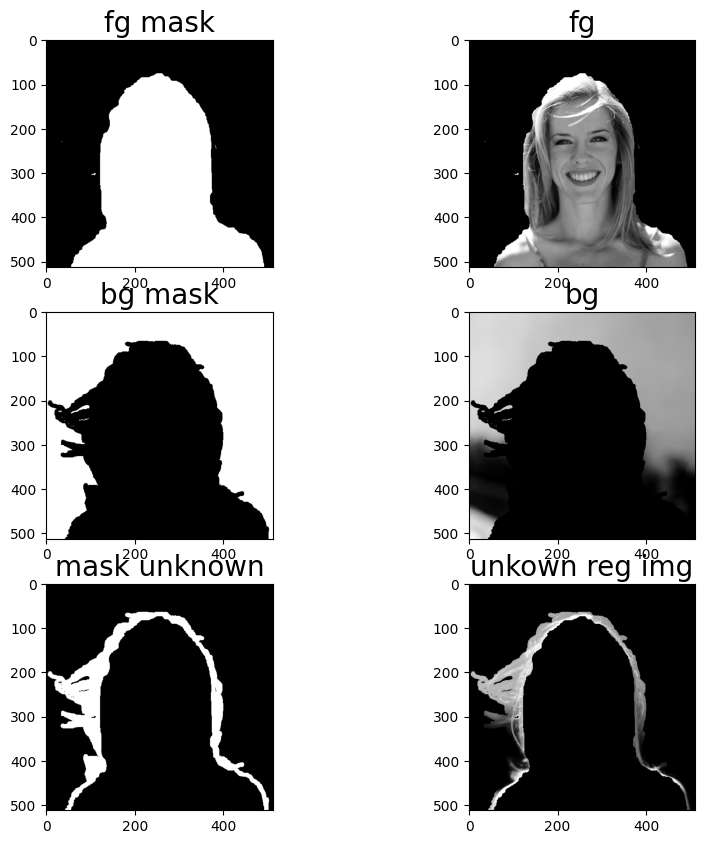

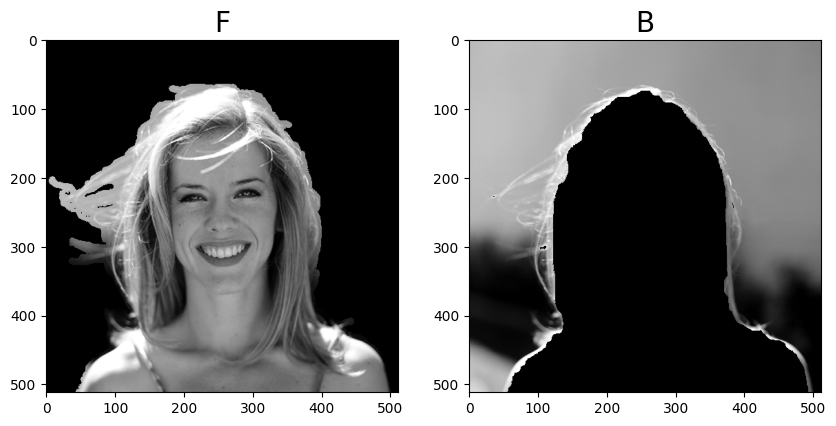

<ipython-input-32-23975e341fe0>:76: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  diff = ndimage.filters.gaussian_filter(diff, 0.9)


[1]
[2]
[3]


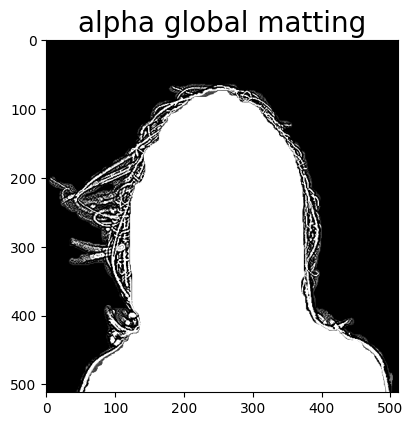

In [ ]:
all_data = matting_combined(tri, img_gray, 2)
## adding images also to this all_data
all_data.update({'img': img, 'img_gray': img_gray})
all_data_3 = all_data.copy()

result['version_2'] = all_data

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])

In [ ]:
print('Parallel version: ', all_data['time'])

Parallel version:  0.007894754409790039


## Parallel 3

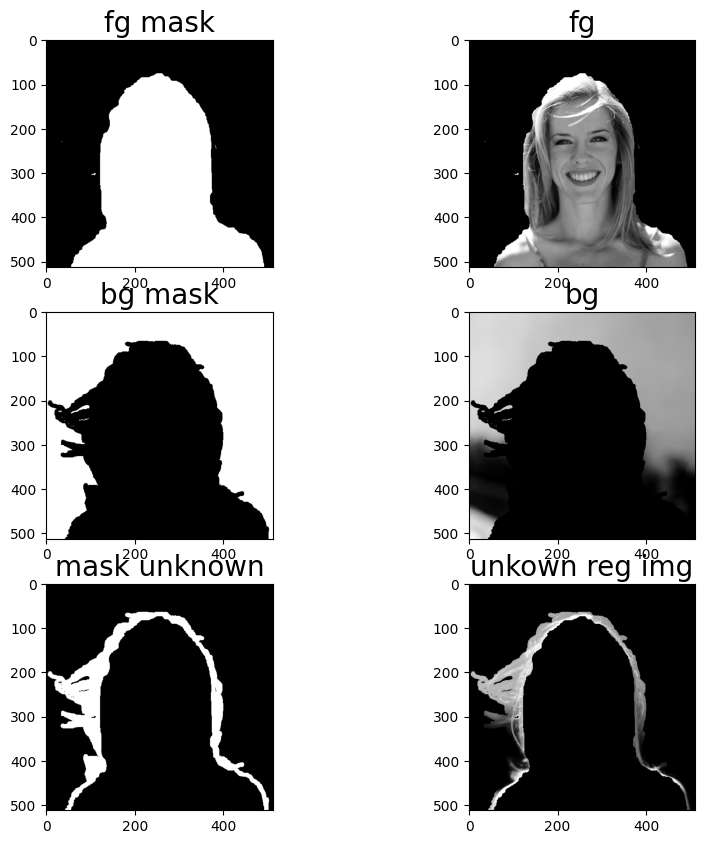

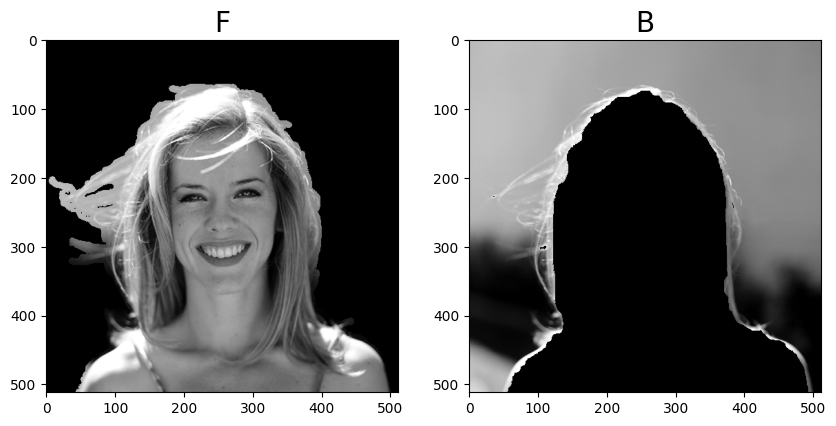

<ipython-input-32-23975e341fe0>:76: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  diff = ndimage.filters.gaussian_filter(diff, 0.9)


blocksize:  (1, 1024)
gridsize:  (512, 1)


/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


[2.1] 0
[2.2] 0
[2.5] 0
[3] 0
d_alpha size: 
(512, 512)
[4] 0


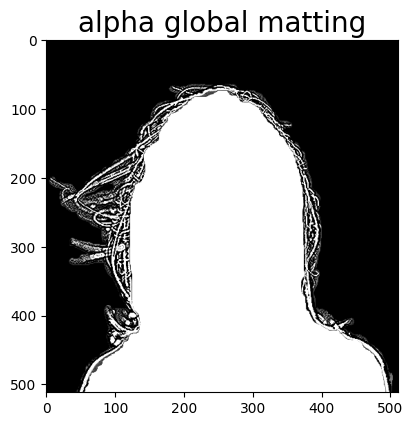

In [ ]:
all_data = matting_combined(tri, img_gray, 3)
## adding images also to this all_data
all_data.update({'img': img, 'img_gray': img_gray})
all_data_3 = all_data.copy()

result['version_3'] = all_data

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])

In [ ]:
print('Parallel version: ', all_data['time'])

Parallel version:  0.006462812423706055


### Alpha blending

#### I = α F + (1 − α )B

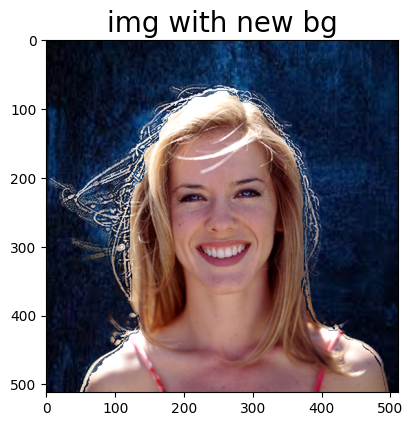

In [ ]:
def alpha_blend(new_bg,alpha,img):
    """
    Utility Function to Calculate the Image on a New Background using the Matte produced by anyone of the methods
    :param new_bg: A numpy array representing the New Background (Coloured)
    :param alpha: A numpy array representing the matte produced
    :param img: Original Image containing the foreground
    """
    new_img = np.zeros(new_bg.shape)
    new_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)*new_bg[:,:,0]
    new_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)*new_bg[:,:,1]
    new_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)*new_bg[:,:,2]
    return np.int64(new_img)

new_img = alpha_blend(new_bg,all_data['alpha'],img)
display_img_arr([new_img ], 1,2,(10,10),['img with new bg'])

# Tính chính xác

In [ ]:
import pandas as pd

sequential_ver = result['sequential']
table = [('sequential', 0, sequential_ver['time'])]

for version in result:
  if version != 'sequential':
    diff = np.mean(np.abs(sequential_ver['alpha'] - result[version]['alpha']))
    table.append((version, diff, result[version]['time']))

data = pd.DataFrame(table, columns=['Version', 'Error', 'Time'])
data

,Version,Error,Time
0,sequential,0.000000,0.421958
1,version_1,0.008950,0.068304
2,version_2,0.013566,0.007895
3,version_3,0.013342,0.006463


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(data, *['Error'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(data, *['Time'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(data, *['Error'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(data, *['Time'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(data, *['Version'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 10 * figscale, 10 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(data, *[[['Error', 'Time']]], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(data, *['Error', 'Version'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(data, *['Time', 'Version'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(data, *['Time', 'Error', 'Version'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(data, *['Time', 'count()', 'Version'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(data, *['Error'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(data, *['Time'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(data, *['Error'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(data, *['Time'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(data, *['Version'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 10 * figscale, 10 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(data, *[[['Error', 'Time']]], **{})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(data, *['Error', 'Version'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def violin_plot(df, value_colname, facet_colname, figscale=1, mpl_palette_name='Dark2', **kwargs):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (12 * figscale, 1.2 * figscale * len(df[facet_colname].unique()))
  plt.figure(figsize=figsize)
  sns.violinplot(df, x=value_colname, y=facet_colname, palette=mpl_palette_name, **kwargs)
  sns.despine(top=True, right=True, bottom=True, left=True)
  return autoviz.MplChart.from_current_mpl_state()

chart = violin_plot(data, *['Time', 'Version'], **{'inner': 'stick'})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(data, *['Time', 'Error', 'Version'], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(data, *['Time', 'count()', 'Version'], **{})
chart

# So sánh kết quả

# Reference

https://github.com/avani17101/Poisson-Matting